In [8]:
import numpy as np
import pandas as pd
from keras.applications.inception_v3 import preprocess_input
from sklearn.model_selection import train_test_split
from keras.applications.inception_v3 import InceptionV3
from keras.layers import Dense, Flatten
from keras.models import Model

In [9]:
# Load your tabular data from CSV
df = pd.read_csv("datasetincsvformat/csv_result-CM1.csv")
df.head()

,id,LOC_BLANK,BRANCH_COUNT,CALL_PAIRS,LOC_CODE_AND_COMMENT,LOC_COMMENTS,CONDITION_COUNT,CYCLOMATIC_COMPLEXITY,CYCLOMATIC_DENSITY,DECISION_COUNT,...,NODE_COUNT,NORMALIZED_CYLOMATIC_COMPLEXITY,NUM_OPERANDS,NUM_OPERATORS,NUM_UNIQUE_OPERANDS,NUM_UNIQUE_OPERATORS,NUMBER_OF_LINES,PERCENT_COMMENTS,LOC_TOTAL,CLASS
0,1,9,5,3,2,2,8,3,0.16,4,...,10,0.10,36,66,21,17,31,19.05,19,N
1,2,19,3,1,2,0,4,2,0.06,2,...,23,0.04,66,69,34,12,55,5.71,35,N
2,3,0,9,0,0,0,10,5,0.56,2,...,9,0.50,10,21,7,9,10,0.00,9,N
3,4,2,15,2,1,9,24,8,0.19,10,...,18,0.15,67,120,43,19,54,19.61,42,N
4,5,5,5,1,0,0,8,3,0.15,4,...,9,0.12,25,46,17,14,26,0.00,20,N


In [10]:
# Preprocess your data and convert it into an image format that can be used by the InceptionV3 model

# Prepare the target and feature data
X = df.drop('CLASS', axis=1) # Replace 'target_variable' with the name of your target variable
y = df['CLASS']

# Convert 'Y' to 1 and 'N' to 0 through simple mapping
y_binary = y.map({'Y': 1, 'N': 0})

# Scale the feature data
X_scaled = (X - X.min()) / (X.max() - X.min())

# Create synthetic images
image_height = 224
image_width = 224

X_images = []
for index, row in X_scaled.iterrows():
    # Create a white image
    img = np.ones((image_height, image_width, 3))

    # Reshape row data to fit the image width
    reshaped_row = row.values.reshape(-1, 1)
    
    # Use the row data to fill the image
    img[:, :reshaped_row.shape[0], :] = reshaped_row
    X_images.append(img)

X_images = np.array(X_images)

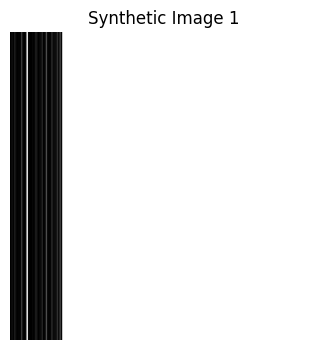

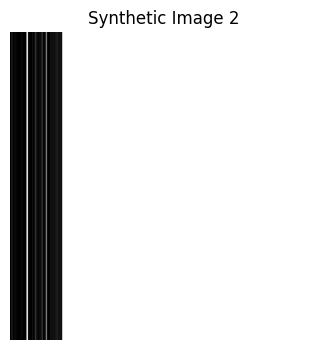

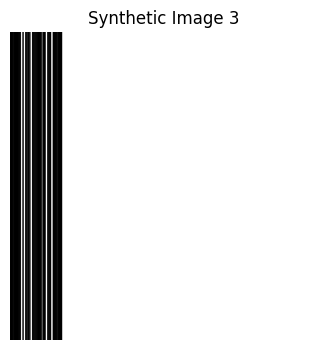

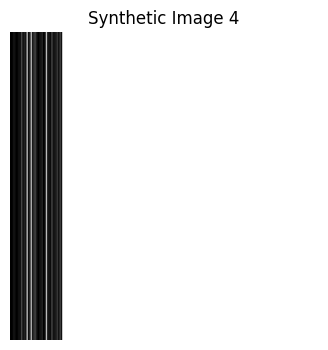

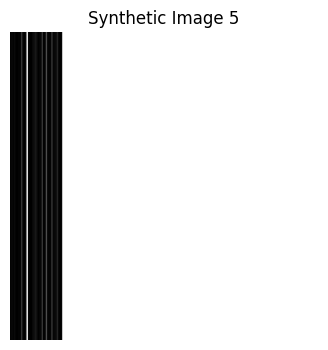

In [11]:
import matplotlib.pyplot as plt

num_images_to_display = 5  # Number of images to display

for i in range(num_images_to_display):
    plt.figure(figsize=(4, 4)) # Adjust the figure size as needed
    
    # plt.imshow(X_images[i])  # Display the synthetic image
    # Display the single-channel (grayscale) image using the 'gray' colormap
    plt.imshow(X_images[i][:, :, 0], cmap='gray')
    
    plt.title(f"Synthetic Image {i + 1}")
    plt.axis('off')
    plt.show()

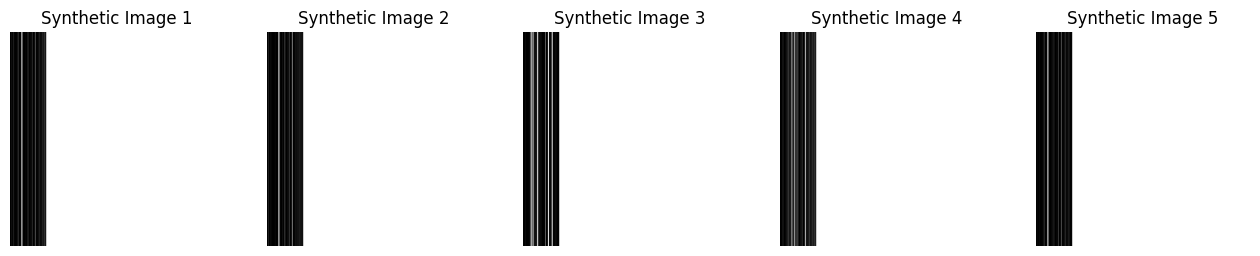

In [12]:
import matplotlib.pyplot as plt

num_images_to_display = 5  # Number of images to display
num_columns = num_images_to_display  # Number of columns for displaying images

# Create a single figure with subplots
fig, axes = plt.subplots(1, num_columns, figsize=(16, 4))  # Adjust the figsize as needed

for i in range(num_images_to_display):
    # Display the grayscale image using the 'gray' colormap
    axes[i].imshow(X_images[i][:, :, 0], cmap='gray')
    axes[i].set_title(f"Synthetic Image {i + 1}")
    axes[i].axis('off')

plt.show()

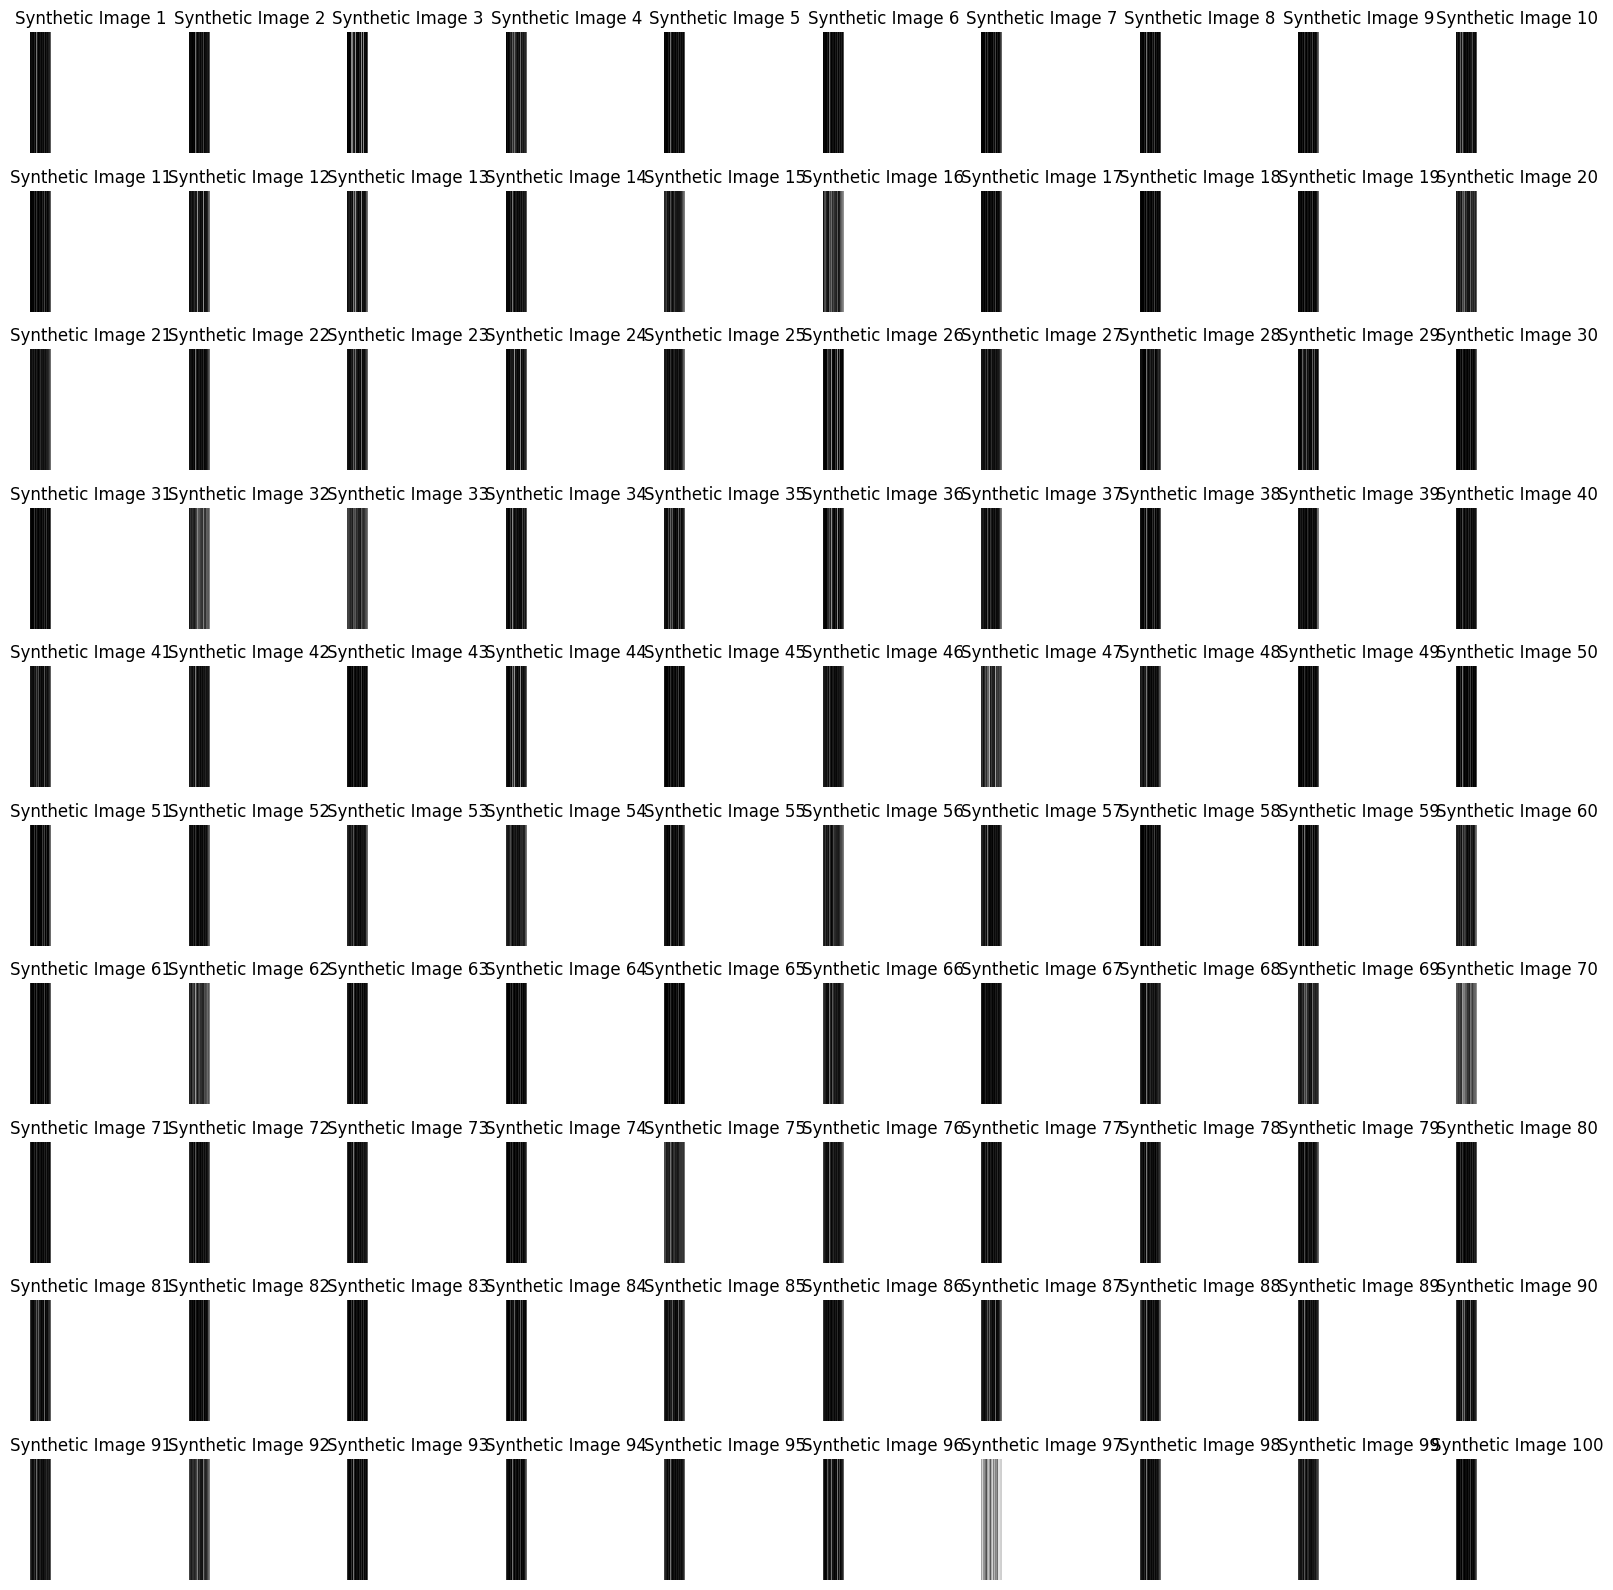

In [13]:
# Display the synthetic images in a grid layout
num_images_to_display = 100  # Number of images to display
num_rows = 10  # Number of rows in the grid layout
num_columns = num_images_to_display // num_rows  # Number of columns based on the number of rows

fig, axes = plt.subplots(num_rows, num_columns, figsize=(16, 16))  # Adjust figsize as needed

for i in range(num_images_to_display):
    row_idx = i // num_columns
    col_idx = i % num_columns
    axes[row_idx, col_idx].imshow(X_images[i][:, :, 0], cmap='gray')
    axes[row_idx, col_idx].set_title(f"Synthetic Image {i + 1}")
    axes[row_idx, col_idx].axis('off')

plt.tight_layout()
plt.show()

In [14]:
# Preprocess the data to match InceptionV3's requirements
X_preprocessed = preprocess_input(X_images)

In [15]:
# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y_binary, test_size=0.2, random_state=42)

In [16]:
# Load the InceptionV3 model without the top classification layer
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(image_height, image_width, 3))

In [17]:
# Add custom layers for your classification task
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)

 # Single output unit for binary classification
predictions = Dense(1, activation='sigmoid')(x)

In [18]:
# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

In [19]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [20]:
# Train the model
# model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

In [21]:
# Evaluate the model
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.5260342955589294
Test accuracy: 0.8333333134651184


3/3 [==============================] - 3s 497ms/step


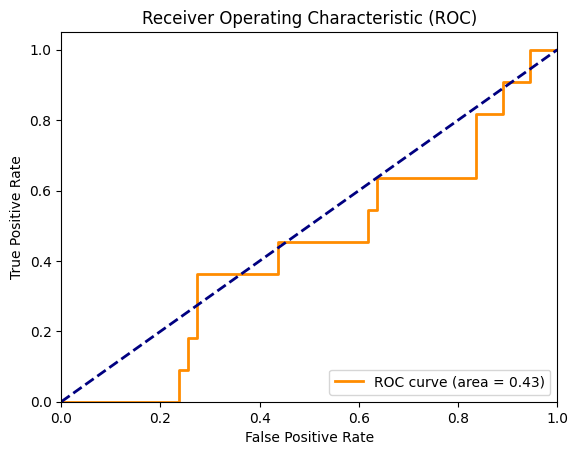

In [22]:
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

In [23]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Make predictions on the test set
y_pred = model.predict(X_test)

# Convert the probability predictions to binary (0 or 1) using a threshold (e.g., 0.5)
y_pred_binary = (y_pred > 0.5).astype(int)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_binary)

# Calculate precision, recall, and F1-score
precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)

# Display the metrics
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-Score: {f1:.2f}')
print(f'AUC Score: {roc_auc:.2f}')

3/3 [==============================] - 2s 587ms/step
Accuracy: 0.83
Precision: 0.00
Recall: 0.00
F1-Score: 0.00
AUC Score: 0.43


C:\Users\Golap\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [==============================] - 2s 519ms/step
Confusion Matrix:
[[55  0]
 [11  0]]


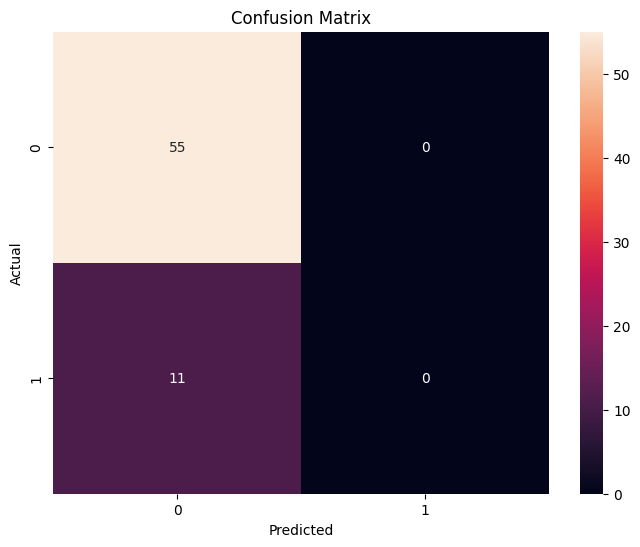

In [24]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Make predictions on the test set
y_pred = model.predict(X_test)

# Convert the probability predictions to binary (0 or 1) using a threshold (e.g., 0.5)
y_pred_binary = (y_pred > 0.5).astype(int)

# Calculate the confusion matrix
confusion = confusion_matrix(y_test, y_pred_binary)

# Display the confusion matrix
print("Confusion Matrix:")
print(confusion)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()